In this notebook, we apply Gaussain process to predict time series data.

Assumeing that a baseball player has the follwoing day-over-day batting averages in the previous 7 days:
0.302, 0.289, 0.201, 0.299, 0.315, 0.337, 0.256

We want to predict his performance in the next 3 days. We will use Gaussain process to do the prediction.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
def kernel(A, B, sigma_f, l_para=2):
    A2 = np.sum(A**2, 1).reshape(-1, 1)  #  a N_a X 1 column vector
    B2 = np.sum(B**2, 1)  # a 1 x N_b row vector
    AdotB = np.dot(A, B.T)  # N_a x N_b 
    squared_dist = (A2 + B2 - 2*AdotB)/(2.0 * l_para)
    k = np.power(sigma_f, 2) * np.exp(-squared_dist)
    return k

def GP_posterior(y, K, Ks, Kss):
    L = np.linalg.cholesky(K)
    m = np.linalg.solve(L, y)
    Lk = np.linalg.solve(L, Ks)    
    mu_s = np.dot(Lk.T, m)
    Sigma_s = Kss - np.dot(Lk.T, Lk)
    return mu_s, Sigma_s

In [3]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

In [12]:
X_train = [1, 2, 3, 4, 5, 6, 7]
y = [0.302, 0.289, 0.201, 0.299, 0.315, 0.337, 0.256]

y_ave = np.mean(y)
y_train = np.array(y) - y_ave   # shift the y values so that the mean is zero.
sigma_f = 1.5 * np.std(y_train)

X_train = np.reshape(X_train, (len(X_train), 1))

# We are mainly interested in x = 8, 9, and 10. 
X_test = np.array([8, 9, 10])

# We include the previous 7 days X's for plotting purpose
X_test = np.concatenate((np.array([1, 2, 3, 4, 5, 6, 7]), X_test))
X_test = np.reshape(X_test, (len(X_test), 1))


In [13]:
K = kernel(X_train, X_train, sigma_f)
Ks = kernel(X_train, X_test, sigma_f)
Kss = kernel(X_test, X_test, sigma_f)

mu_s, Sigma_s = GP_posterior(y_train, K, Ks, Kss)

mu_s += y_ave  # shift the y-values back to the original scale

posterior_std = np.sqrt(np.diag(Sigma_s))

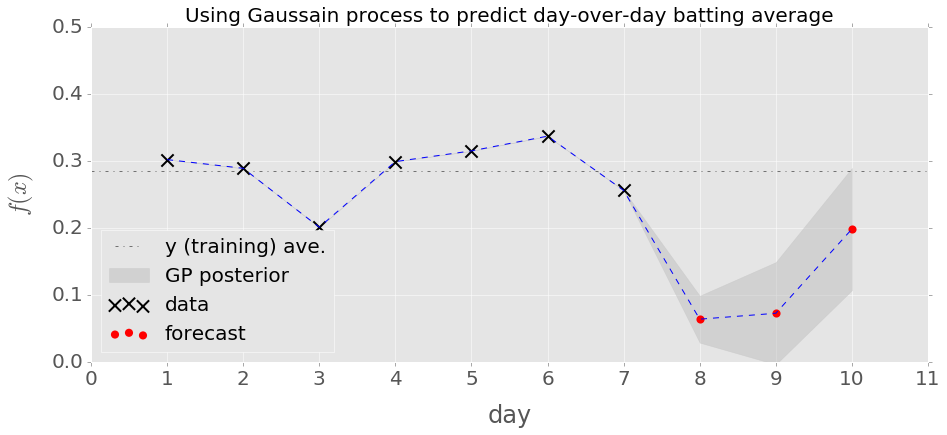

In [26]:
FONTSIZE = 20
plt.close('all')
fig, ax = plt.subplots(1, figsize=(15, 6))

ax.plot(X_test.flatten(), mu_s, linestyle='--', color='b')
ax.fill_between(X_test.flatten(), mu_s-1.5*posterior_std, mu_s+1.5*posterior_std, 
                alpha=0.5, color='0.75', label='GP posterior')
ax.axhline(y_ave, linewidth=1, color='k', alpha=0.5, linestyle='-.', label='y (training) ave.')
ax.scatter(X_train, y_ave + y_train, marker='x', s=150, linewidth=2, color='k', label='data')
ax.scatter([8, 9, 10],  mu_s[-3:], marker='.', s=150, linewidth=2, color='r', label='forecast')
ax.legend(loc='best', fontsize=FONTSIZE)

Y_MIN = 0
Y_MAX = 0.5

ax.set_xlim(0, 11)
ax.set_xticks(np.arange(0, 12))
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_xlabel('day', fontsize=FONTSIZE*1.2, labelpad=15)
ax.set_ylabel(r'$f(x)$', fontsize=FONTSIZE*1.2, labelpad=15)
ax.legend(loc=3, fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
t = ax.set_title('Using Gaussain process to predict day-over-day batting average', fontsize=FONTSIZE)

One interesting thing to notice is that, the predicted values on day-8 and day-9 are lower, as the data shows downward trend on day-7. As we move away from day-7, since we use l=2 in the kernel, on day-10 the prediction goes back to the average value of y.

Also notice that as we move to the right, the uncertainty becomes bigger, as we are moving away from the data.